Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/automated-machine-learning/regression-car-price-model-explaination-and-featurization/auto-ml-regression.png)

# Automated Machine Learning
_**Regression with Aml Compute**_

## Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Results](#Results)
1. [Test](#Test)


## Introduction
In this example we use the Hardware Performance Dataset to showcase how you can use AutoML for a simple regression problem. The Regression goal is to predict the performance of certain combinations of hardware parts.
After training AutoML models for this regression data set, we show how you can compute model explanations on your remote compute using a sample explainer script.

If you are using an Azure Machine Learning Compute Instance, you are all set.  Otherwise, go through the [configuration](../../../configuration.ipynb)  notebook first if you haven't already to establish your connection to the AzureML Workspace. 

In this notebook you will learn how to:
1. Create an `Experiment` in an existing `Workspace`.
2. Instantiating AutoMLConfig with FeaturizationConfig for customization
3. Train the model using remote compute.
4. Explore the results and featurization transparency options
5. Setup remote compute for computing the model explanations for a given AutoML model.
6. Start an AzureML experiment on your remote compute to compute explanations for an AutoML model.
7. Download the feature importance for engineered features and visualize the explanations for engineered features on azure portal. 
8. Download the feature importance for raw features and visualize the explanations for raw features on azure portal. 


## Setup

As part of the setup you have already created an Azure ML `Workspace` object. For Automated ML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [1]:
%env AZURE_EXTENSION_DIR=/home/schrodinger/automl/sdk-cli-v2/src/cli/src
%env AZURE_ML_CLI_PRIVATE_FEATURES_ENABLED=true

env: AZURE_EXTENSION_DIR=/home/schrodinger/automl/sdk-cli-v2/src/cli/src
env: AZURE_ML_CLI_PRIVATE_FEATURES_ENABLED=true


In [2]:
import azure.ml
from azure.ml import MLClient

from azure.core.exceptions import ResourceExistsError

from azure.ml.entities import Workspace
from azure.ml.entities import AmlCompute
from azure.ml.entities import Data

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import logging

This sample notebook may use features that are not available in previous versions of the Azure ML SDK.

In [3]:
# TODO: Versions need to change
print("This notebook was created using version 1.31.0 of the Azure ML SDK")
print("You are currently using SDK version", azure.ml.version.VERSION, "of the Azure ML SDK")

This notebook was created using version 1.31.0 of the Azure ML SDK
You are currently using SDK version 0.0.86 of the Azure ML SDK


In [4]:
subscription_id = '381b38e9-9840-4719-a5a0-61d9585e1e91'
resource_group_name = 'gasi_rg_centraleuap'
workspace_name = "gasi_ws_centraleuap"
experiment_name = "automl-regression-hardware-explain"

client = MLClient(subscription_id, resource_group_name, default_workspace_name=workspace_name)

client

In [5]:
import mlflow

########
# TODO: The API to get tracking URI is not yet available on Worksapce object.
from azureml.core import Workspace as WorkspaceV1
ws = WorkspaceV1(workspace_name=workspace_name, resource_group=resource_group_name, subscription_id=subscription_id)
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())
del ws
########

# Not sure why this doesn't work w/o the double + single quotes
# mlflow.set_tracking_uri("azureml://northeurope.experiments.azureml.net/mlflow/v1.0/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/gasi_rg_neu/providers/Microsoft.MachineLearningServices/workspaces/gasi_ws_neu?")
mlflow.set_experiment(experiment_name)

print("\nCurrent tracking uri: {}".format(mlflow.get_tracking_uri()))

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.



Current tracking uri: azureml://master.experiments.azureml-test.net/mlflow/v1.0/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/gasi_rg_centraleuap/providers/Microsoft.MachineLearningServices/workspaces/gasi_ws_centraleuap?


### Create or Attach existing AmlCompute
You will need to create a [compute target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) for your AutoML run. In this tutorial, you create `AmlCompute` as your training compute resource.

> Note that if you have an AzureML Data Scientist role, you will not have permission to create compute resources. Talk to your workspace or IT admin to create the compute targets described in this section, if they do not already exist.

**Creation of AmlCompute takes approximately 5 minutes.** If the AmlCompute with that name is already in your workspace this code will skip the creation process.

As with other Azure services, there are limits on certain resources (e.g. AmlCompute) associated with the Azure Machine Learning service. Please read [this article](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-manage-quotas) on the default limits and how to request more quota.

In [6]:
# Set or create compute

cpu_cluster_name = "cpu-cluster"
compute = AmlCompute(
    name=cpu_cluster_name, size="STANDARD_D2_V2",
    min_instances=0, max_instances=3,
    idle_time_before_scale_down=120
)

# Load directly from YAML file
# compute = Compute.load("./compute.yaml")

try:
    # TODO: This currently results in an exception in Azure ML, please create compute manually.
    client.compute.create(compute)
except ResourceExistsError as re:
    print(re)
except Exception as e:
    import traceback
    
    print("Could not create compute.", str(e))
#     traceback.print_exc()
    # Reload an existing compute target
    compute = client.compute.get(cpu_cluster_name)

compute

Could not create compute. Cannot deserialize duration object., ISO8601Error: Unable to parse duration string ''


AmlCompute({'name': 'cpu-cluster', 'id': '/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/gasi_rg_centraleuap/providers/Microsoft.MachineLearningServices/workspaces/gasi_ws_centraleuap/computes/cpu-cluster', 'description': None, 'tags': {}, 'properties': {}, 'base_path': './', 'location': 'centraluseuap', 'type': 'amlcompute', 'enable_public_ip': False, 'resource_id': None, 'provisioning_state': 'Succeeded', 'provisioning_errors': None, 'created_on': None, 'size': 'STANDARD_D2_V2', 'min_instances': 0, 'max_instances': 4, 'idle_time_before_scale_down': 120.0, 'identity_type': None, 'user_assigned_identities': None, 'admin_username': 'azureuser', 'admin_password': None, 'ssh_key_value': None, 'vnet_name': None, 'subnet': None, 'priority': 'Dedicated'})

### Setup Training and Test Data for AutoML experiment

Load the hardware dataset from a csv file containing both training features and labels. The features are inputs to the model, while the training labels represent the expected output of the model. Next, we'll split the data using random_split and extract the training data for the model.  We also register the datasets in your workspace using a name so that these datasets may be accessed from the remote compute.

In [7]:
data = "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/machineData.csv"
pdf = pd.read_csv(data)

# 80/20 split
train=pdf.sample(frac=0.8, random_state=42)
test=pdf.drop(train.index)

label = "ERP"
train.shape, test.shape

((167, 10), (42, 10))

In [8]:
# Save the CSV file locally, so that it can be uploaded to create a 
# tabular dataset

import os

if not os.path.isdir('data'):
    os.mkdir('data')
    
# Save the train-test-valid data to a csv to be uploaded to the datastore
train.to_csv("data/train_data.csv", index=False)

In [9]:
# TODO: This doesnt' work, ensure dataset is created via. the UI
# Create dataset

dataset_name = "machine_data_train"
dataset_version = 1

try:
    training_data = client.data.get(dataset_name, dataset_version)
#     training_data = Data(name=dataset_name, version=dataset_version, local_path="./data")
#     training_data = client.data.create_or_update(training_data)
#     print("Uploaded to path  : ", data.path)
#     print("Datastore location: ", data.datastore)
except Exception as e:
    print("Could not create dataset. ", str(e))

training_data

Data({'is_anonymous': False, 'name': 'machine_data_train', 'id': '/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/gasi_rg_centraleuap/providers/Microsoft.MachineLearningServices/workspaces/gasi_ws_centraleuap/data/machine_data_train/versions/1', 'description': None, 'tags': {}, 'properties': {}, 'base_path': './', 'creation_context': <azure.ml._restclient.v2021_03_01_preview.models._models_py3.SystemData object at 0x7f5166799350>, 'version': 1, 'datastore': '/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/gasi_rg_centraleuap/providers/Microsoft.MachineLearningServices/workspaces/gasi_ws_centraleuap/datastores/workspaceblobstore', 'path': 'UI/07-14-2021_062933_UTC/train_data.csv', 'local_path': None})

## Train

Instantiate an `AutoMLConfig` object to specify the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|classification, regression or forecasting|
|**primary_metric**|This is the metric that you want to optimize. Regression supports the following primary metrics: <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>|
|**experiment_timeout_hours**| Maximum amount of time in hours that all iterations combined can take before the experiment terminates.|
|**enable_early_stopping**| Flag to enble early termination if the score is not improving in the short term.|
|**featurization**| 'auto' / 'off' / FeaturizationConfig Indicator for whether featurization step should be done automatically or not, or whether customized featurization should be used. Setting this enables AutoML to perform featurization on the input to handle *missing data*, and to perform some common *feature extraction*. Note: If the input data is sparse, featurization cannot be turned on.|
|**n_cross_validations**|Number of cross validation splits.|
|**training_data**|(sparse) array-like, shape = [n_samples, n_features]|
|**label_column_name**|(sparse) array-like, shape = [n_samples, ], targets values.|

## Customization

Supported customization includes:

1. Column purpose update: Override feature type for the specified column.
2. Transformer parameter update: Update parameters for the specified transformer. Currently supports Imputer and HashOneHotEncoder.
3. Drop columns: Columns to drop from being featurized.
4. Block transformers: Allow/Block transformers to be used on featurization process.

Create FeaturizationConfig object using API calls

In [35]:
from pprint import pprint

pprint(job.featurization_settings.featurization_config.transformer_params)

pprint(job.featurization_settings.featurization_config.transformer_params["hash_one_hot_encoder"][0].__dict__)

{'Imputer': [<azure.ml.entities._job.automl.featurization.ColumnTransformer object at 0x7f5145620e90>,
 'hash_one_hot_encoder': [<azure.ml.entities._job.automl.featurization.ColumnTransformer object at 0x7f5145620bd0>]}
{'fields': ['ModelName'], 'parameters': {'number_of_bits': 3.0}}


In [38]:
from azure.ml.entities._job.automl.featurization import (
    ColumnTransformer, FeaturizationConfig, FeaturizationSettings
)

featurization_config = FeaturizationConfig()
featurization_config.blocked_transformers = ['LabelEncoder']
featurization_config.drop_columns = ['MMIN']

featurization_config.column_purposes = {
    'MYCT': 'Numeric',
    'VendorName': 'CategoricalHash'
}

#default strategy mean, add transformer param for for 3 columns
transformer_params_dict = {
    "Imputer": [
        ColumnTransformer(fields=["CACH"], parameters={'strategy': 'median'}),
        ColumnTransformer(fields=["CHMIN"], parameters={'strategy': 'median'}),
        ColumnTransformer(fields=["PRP"], parameters={'strategy': 'most_frequent'}),
    ],
    "HashOneHotEncoder": [
        ColumnTransformer(fields=[], parameters={'number_of_bits': 3.0})
    ]
}

featurization_config.transformer_params = transformer_params_dict

In [45]:
from azure.ml._restclient.v2020_09_01_preview.models import (
    GeneralSettings,
    DataSettings,
    LimitSettings,
    TrainingDataSettings,
    ValidationDataSettings,
    TestDataSettings,
)

from azure.ml.entities._job.automl.training_settings import TrainingSettings
from azure.ml.entities._job.automl.featurization import FeaturizationSettings
from azure.ml.entities import AutoMLJob, ComputeConfiguration
    
        
compute_settings = ComputeConfiguration(target=cpu_cluster_name)

general_settings = GeneralSettings(
    task_type="regression",
    primary_metric= "normalized_root_mean_squared_error",
    log_verbosity="Info")

limit_settings = LimitSettings(
    timeout=15,
    trial_timeout=5,
    max_concurrent_trials=4,
    max_cores_per_trial=-1,
    enable_early_termination=True)

training_data_settings = TrainingDataSettings(
    dataset_arm_id="{}:{}".format(training_data.name, training_data.version)
)

validation_data_settings = ValidationDataSettings(n_cross_validations=5)

data_settings = DataSettings(
    training_data=training_data_settings,
    target_column_name=label,
    validation_data=validation_data_settings
)

featurization_settings = FeaturizationSettings(featurization_config=featurization_config)

extra_automl_settings = {"save_mlflow": True}

automl_job = AutoMLJob(
    compute=compute_settings,
    general_settings=general_settings,
    limit_settings=limit_settings,
    data_settings=data_settings,
    featurization_settings=featurization_settings,
    properties=extra_automl_settings,
)

automl_job

AutoMLJob({'name': 'ddf6673e-4793-4474-a8f9-c5a393f88413', 'id': None, 'description': None, 'tags': {}, 'properties': {'save_mlflow': True}, 'base_path': './', 'type': 'automl_job', 'creation_context': None, 'experiment_name': 'regression-explanation-featurization', 'status': None, 'interaction_endpoints': None, 'log_files': None, 'output': None, 'general_settings': <azure.ml._restclient.v2020_09_01_preview.models._models_py3.GeneralSettings object at 0x7f5145aee810>, 'data_settings': <azure.ml._restclient.v2020_09_01_preview.models._models_py3.DataSettings object at 0x7f5145aee850>, 'limit_settings': <azure.ml._restclient.v2020_09_01_preview.models._models_py3.LimitSettings object at 0x7f5145aee8d0>, 'forecasting_settings': None, 'training_settings': None, 'featurization_settings': <azure.ml.entities._job.automl.featurization.FeaturizationSettings object at 0x7f5145aeea10>, 'compute': {'instance_count': None, 'target': 'cpu-cluster', 'is_local': False, 'instance_type': None, 'location

Call the `submit` method on the experiment object and pass the run configuration. Execution of local runs is synchronous. Depending on the data and the number of iterations this can run for a while.
In this example, we specify `show_output = True` to print currently running iterations to the console.

In [46]:
automl_job.dump("/tmp/dumped.yaml")

In [43]:
created_job = client.jobs.create_or_update(automl_job)
created_job

HttpResponseError: Operation returned an invalid status 'Received 500 from a service request'

Run the following cell to access previous runs. Uncomment the cell below and update the run_id.

In [ ]:
#from azureml.train.automl.run import AutoMLRun
#remote_run = AutoMLRun(experiment=experiment, run_id='<run_ID_goes_here')
#remote_run

In [ ]:
# remote_run.wait_for_completion()

In [47]:
from mlflow.tracking import MlflowClient

# TODO: Use this run, as it has MLFlow model stored on the run
job_name = "AutoML_63a6198d-fd94-415c-89a8-2d774e63a0c2"
# job_name = created_job.name

mlflow_client = MlflowClient()
mlflow_parent_run = mlflow_client.get_run(job_name)

best_child_run_id = mlflow_parent_run.data.tags["automl_best_child_run_id"]
print("Found best child run id: ", best_child_run_id)

best_run = mlflow_client.get_run(best_child_run_id)
best_run

Found best child run id:  AutoML_63a6198d-fd94-415c-89a8-2d774e63a0c2_30


<Run: data=<RunData: metrics={'explained_variance': 0.9469377156576257,
 'mean_absolute_error': 16.344931726318706,
 'mean_absolute_percentage_error': 13.440869393270205,
 'median_absolute_error': 4.962546667916155,
 'normalized_mean_absolute_error': 0.013364621198952334,
 'normalized_median_absolute_error': 0.004057683293471918,
 'normalized_root_mean_squared_error': 0.031322641934272775,
 'normalized_root_mean_squared_log_error': 0.03984624176365959,
 'r2_score': 0.9432604716952184,
 'root_mean_squared_error': 38.307591085615606,
 'root_mean_squared_log_error': 0.17331007936109333,
 'spearman_correlation': 0.9783322136381037}, params={}, tags={'_aml_system_ComputeTargetStatus': '{"AllocationState":"steady","PreparingNodeCount":0,"RunningNodeCount":2,"CurrentNodeCount":4}',
 '_aml_system_automl_is_child_run_end_telemetry_event_logged': 'True',
 '_aml_system_azureml.automlComponent': 'AutoML',
 'mlflow.parentRunId': 'AutoML_63a6198d-fd94-415c-89a8-2d774e63a0c2',
 'mlflow.source.name': 

In [48]:
# This step requires AutoML runtime libraries to be installed
# !pip install azureml-train-automl-runtime

import mlflow.sklearn

fitted_model = mlflow.sklearn.load_model("runs:/{}/outputs".format(best_run.info.run_id))

## Transparency

View updated featurization summary

In [49]:
custom_featurizer = fitted_model.named_steps['datatransformer']

In [50]:
custom_featurizer.get_featurization_summary()

[{'RawFeatureName': 'VendorName',
  'TypeDetected': 'CategoricalHash',
  'Dropped': 'No',
  'EngineeredFeatureCount': 16,
  'Transformations': ['StringCast-HashOneHotEncoder']},
 {'RawFeatureName': 'ModelName',
  'TypeDetected': 'Hashes',
  'Dropped': 'Yes',
  'EngineeredFeatureCount': 0,
  'Transformations': ['']},
 {'RawFeatureName': 'MYCT',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureCount': 1,
  'Transformations': ['MeanImputer']},
 {'RawFeatureName': 'MMIN',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureCount': 1,
  'Transformations': ['MeanImputer']},
 {'RawFeatureName': 'MMAX',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureCount': 1,
  'Transformations': ['MeanImputer']},
 {'RawFeatureName': 'CACH',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureCount': 1,
  'Transformations': ['MeanImputer']},
 {'RawFeatureName': 'CHMIN',
  'TypeDetected': 'Numeric',
  'Dropped': 'No',
  'EngineeredFeatureC

is_user_friendly=False allows for more detailed summary for transforms being applied

In [51]:
custom_featurizer.get_featurization_summary(is_user_friendly=False)

[{'RawFeatureName': 'VendorName',
  'TypeDetected': 'CategoricalHash',
  'Dropped': 'No',
  'EngineeredFeatureCount': 16,
  'Transformations': ['StringCast-HashOneHotEncoder'],
  'TransformationParams': {'Transformer1': {'Input': ['VendorName'],
    'TransformationFunction': 'StringCast',
    'Operator': None,
    'FeatureType': 'CategoricalHash',
    'ShouldOutput': False,
    'TransformationParams': {}},
   'Transformer2': {'Input': ['Transformer1'],
    'TransformationFunction': 'HashOneHotEncoder',
    'Operator': None,
    'FeatureType': None,
    'ShouldOutput': True,
    'TransformationParams': {'hashing_seed_val': 314489979, 'num_cols': 16}}}},
 {'RawFeatureName': 'ModelName',
  'TypeDetected': 'Hashes',
  'Dropped': 'Yes',
  'EngineeredFeatureCount': 0,
  'Transformations': [''],
  'TransformationParams': {'Transformer1': {'Input': ['ModelName'],
    'TransformationFunction': '',
    'Operator': None,
    'FeatureType': 'Hashes',
    'ShouldOutput': True,
    'TransformationPa

In [53]:
custom_featurizer.get_stats_feature_type_summary()

## Results

#### Widget for Monitoring Runs

The widget will first report a "loading" status while running the first iteration. After completing the first iteration, an auto-updating graph and table will be shown. The widget will refresh once per minute, so you should see the graph update as child runs complete.

**Note:** The widget displays a link at the bottom. Use this link to open a web interface to explore the individual run details

In [ ]:
# from azureml.widgets import RunDetails
# RunDetails(remote_run).show() 

## Explanations
This section will walk you through the workflow to compute model explanations for an AutoML model on your remote compute.

### Retrieve any AutoML Model for explanations

Below we select an AutoML pipeline from our iterations. The `get_output` method returns the a AutoML run and the fitted model for the last invocation. Overloads on `get_output` allow you to retrieve the best run and fitted model for any logged `metric` or for a particular `iteration`.

In [56]:
#automl_run, fitted_model = remote_run.get_output(metric='r2_score')

iteration = 2

child_run_id = "{}_{}".format(mlflow_parent_run.info.run_id, (iteration-1))

automl_mlflow_run = mlflow_client.get_run(child_run_id)
fitted_model = mlflow.sklearn.load_model("runs:/{}/outputs".format(automl_mlflow_run.info.run_id))

### Setup model explanation run on the remote compute
The following section provides details on how to setup an AzureML experiment to run model explanations for an AutoML model on your remote compute.

#### Sample script used for computing explanations
View the sample script for computing the model explanations for your AutoML model on remote compute.

In [57]:
with open('train_explainer.py', 'r') as cefr:
    print(cefr.read())

# Copyright (c) Microsoft. All rights reserved.
# Licensed under the MIT license.
import os
import joblib

from interpret.ext.glassbox import LGBMExplainableModel
from azureml.automl.core.shared.constants import MODEL_PATH
from azureml.core.experiment import Experiment
from azureml.core.dataset import Dataset
from azureml.core.run import Run
from azureml.interpret.mimic_wrapper import MimicWrapper
from azureml.interpret.scoring.scoring_explainer import TreeScoringExplainer
from azureml.train.automl.runtime.automl_explain_utilities import automl_setup_model_explanations, \
    automl_check_model_if_explainable


OUTPUT_DIR = './outputs/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Get workspace from the run context
run = Run.get_context()
ws = run.experiment.workspace

# Get the AutoML run object from the experiment name and the workspace
experiment = Experiment(ws, '<<experiment_name>>')
automl_run = Run(experiment=experiment, run_id='<<run_id>>')

# Check if this AutoML model is explain

#### Substitute values in your sample script
The following cell shows how you change the values in the sample script so that you can change the sample script according to your experiment and dataset.

In [60]:
import shutil
import os

# create script folder
script_folder = './sample_projects/automl-regression-hardware'
if not os.path.exists(script_folder):
    os.makedirs(script_folder)

# Copy the sample script to script folder.
shutil.copy('train_explainer.py', script_folder)

# Create the explainer script that will run on the remote compute.
script_file_name = script_folder + '/train_explainer.py'

# Open the sample script for modification
with open(script_file_name, 'r') as cefr:
    content = cefr.read()

# Replace the values in train_explainer.py file with the appropriate values
content = content.replace('<<experiment_name>>', experiment_name) # your experiment name.
content = content.replace('<<run_id>>', automl_mlflow_run.info.run_id) # Run-id of the AutoML run for which you want to explain the model.
content = content.replace('<<target_column_name>>', 'ERP') # Your target column name
content = content.replace('<<task>>', 'regression') # Training task type
# Name of your training dataset register with your workspace
content = content.replace('<<train_dataset_name>>', 'machine_data_train') 
# Name of your test dataset register with your workspace
content = content.replace('<<test_dataset_name>>', 'machine_data_train')

# Write sample file into your script folder.
with open(script_file_name, 'w') as cefw:
    cefw.write(content)

#### Submit the experiment for model explanations
Submit the experiment with the above `run_config` and the sample script for computing explanations.

In [73]:
# Using a 'CommandJob' to submit the custom script to run the explainer

from azure.ml.entities import CommandJob, Code

environment = client.environments.get("environment-AutoML")
compute = compute_settings

command_job = CommandJob(
    command="python train_explainer.py",
    code=Code(local_path=script_folder),
    environment=environment,
    compute=compute
)

In [75]:
created_command_job = client.jobs.create_or_update(command_job)
created_command_job

CommandJob({'name': 'd8d97915-c133-4832-8e66-6ffc0cc5a68c', 'id': '/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/gasi_rg_centraleuap/providers/Microsoft.MachineLearningServices/workspaces/gasi_ws_centraleuap/jobs/d8d97915-c133-4832-8e66-6ffc0cc5a68c', 'description': None, 'tags': {}, 'properties': {'mlflow.source.git.repoURL': 'https://github.com/Azure/MachineLearningNotebooks.git', 'mlflow.source.git.branch': 'master', 'mlflow.source.git.commit': '421ea3d920facdb2a89db97ff609ab4d8bb7528f', 'azureml.git.dirty': 'True', '_azureml.ComputeTargetType': 'amlcompute', 'ContentSnapshotId': '1ec12f7f-9df2-41ab-bbb9-4f0625e12afb'}, 'base_path': None, 'inputs': {}, 'command': 'python train_explainer.py', 'input_ports': {}, 'data_bindings': {}, 'code': 'd5474d37-95cc-408e-955e-22050b5124fe:1', 'environment': 'environment-AutoML:1', 'distribution': None, 'compute': {'instance_count': 1, 'target': 'cpu-cluster', 'is_local': False, 'instance_type': None, 'location': None, 'prope

In [ ]:
# %%time
# # Shows output of the run on stdout.
# run.wait_for_completion(show_output=True)

### Feature importance  and  visualizing explanation dashboard
In this section we describe how you can download the explanation results from the explanations experiment and visualize the feature importance for your AutoML model on the azure portal.

#### Download engineered feature importance from artifact store
You can use *ExplanationClient* to download the engineered feature explanations from the artifact store of the *automl_run*. You can also use azure portal url to view the dash board visualization of the feature importance values of the engineered features.

In [ ]:
# from azureml.interpret import ExplanationClient
# client = ExplanationClient.from_run(automl_run)
# engineered_explanations = client.download_model_explanation(raw=False, comment='engineered explanations')
# print(engineered_explanations.get_feature_importance_dict())
# print("You can visualize the engineered explanations under the 'Explanations (preview)' tab in the AutoML run at:-\n" + automl_run.get_portal_url())

#### Download raw feature importance from artifact store
You can use *ExplanationClient* to download the raw feature explanations from the artifact store of the *automl_run*. You can also use azure portal url to view the dash board visualization of the feature importance values of the raw features.

In [ ]:
# raw_explanations = client.download_model_explanation(raw=True, comment='raw explanations')
# print(raw_explanations.get_feature_importance_dict())
# print("You can visualize the raw explanations under the 'Explanations (preview)' tab in the AutoML run at:-\n" + automl_run.get_portal_url())

## Operationalize
### Please check other notebooks for deployment steps (e.g. autom-ml-classification-bank-marketing-all-features)

In this section we will show how you can operationalize an AutoML model and the explainer which was used to compute the explanations in the previous section.

### Register the AutoML model and the scoring explainer
We use the *TreeScoringExplainer* from *azureml-interpret* package to create the scoring explainer which will be used to compute the raw and engineered feature importances at the inference time. 
In the cell below, we register the AutoML model and the scoring explainer with the Model Management Service.

In [ ]:
# # Register trained automl model present in the 'outputs' folder in the artifacts
# original_model = automl_run.register_model(model_name='automl_model', 
#                                            model_path='outputs/model.pkl')
# scoring_explainer_model = automl_run.register_model(model_name='scoring_explainer',
#                                                     model_path='outputs/scoring_explainer.pkl')

### Create the conda dependencies for setting up the service
We need to create the conda dependencies comprising of the *azureml* packages using the training environment from the *automl_run*.

In [ ]:
# conda_dep = automl_run.get_environment().python.conda_dependencies

# with open("myenv.yml","w") as f:
#     f.write(conda_dep.serialize_to_string())

# with open("myenv.yml","r") as f:
#     print(f.read())

### View your scoring file

In [ ]:
# with open("score_explain.py","r") as f:
#     print(f.read())

### Deploy the service
In the cell below, we deploy the service using the conda file and the scoring file from the previous steps. 

In [ ]:
# from azureml.core.webservice import Webservice
# from azureml.core.model import InferenceConfig
# from azureml.core.webservice import AciWebservice
# from azureml.core.model import Model
# from azureml.core.environment import Environment

# aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
#                                                memory_gb=1, 
#                                                tags={"data": "Machine Data",  
#                                                      "method" : "local_explanation"}, 
#                                                description='Get local explanations for Machine test data')

# myenv = Environment.from_conda_specification(name="myenv", file_path="myenv.yml")
# inference_config = InferenceConfig(entry_script="score_explain.py", environment=myenv)

# # Use configs and models generated above
# service = Model.deploy(ws, 'model-scoring', [scoring_explainer_model, original_model], inference_config, aciconfig)
# service.wait_for_deployment(show_output=True)

### View the service logs

In [ ]:
service.get_logs()

### Inference using some test data
Inference using some test data to see the predicted value from autml model, view the engineered feature importance for the predicted value and raw feature importance for the predicted value.

In [ ]:
if service.state == 'Healthy':
    X_test = test_data.drop_columns([label]).to_pandas_dataframe()
    # Serialize the first row of the test data into json
    X_test_json = X_test[:1].to_json(orient='records')
    print(X_test_json)
    # Call the service to get the predictions and the engineered and raw explanations
    output = service.run(X_test_json)
    # Print the predicted value
    print(output['predictions'])
    # Print the engineered feature importances for the predicted value
    print(output['engineered_local_importance_values'])
    # Print the raw feature importances for the predicted value
    print(output['raw_local_importance_values'])

### Delete the service
Delete the service once you have finished inferencing.

In [ ]:
service.delete()

## Test

In [78]:
# preview the first 3 rows of the dataset

test_data = test
y_test = test_data['ERP'].fillna(0)
test_data = test_data.drop('ERP', 1)
test_data = test_data.fillna(0)


train_data = train
y_train = train_data['ERP'].fillna(0)
train_data = train_data.drop('ERP', 1)
train_data = train_data.fillna(0)

In [79]:
y_pred_train = fitted_model.predict(train_data)
y_residual_train = y_train - y_pred_train

y_pred_test = fitted_model.predict(test_data)
y_residual_test = y_test - y_pred_test

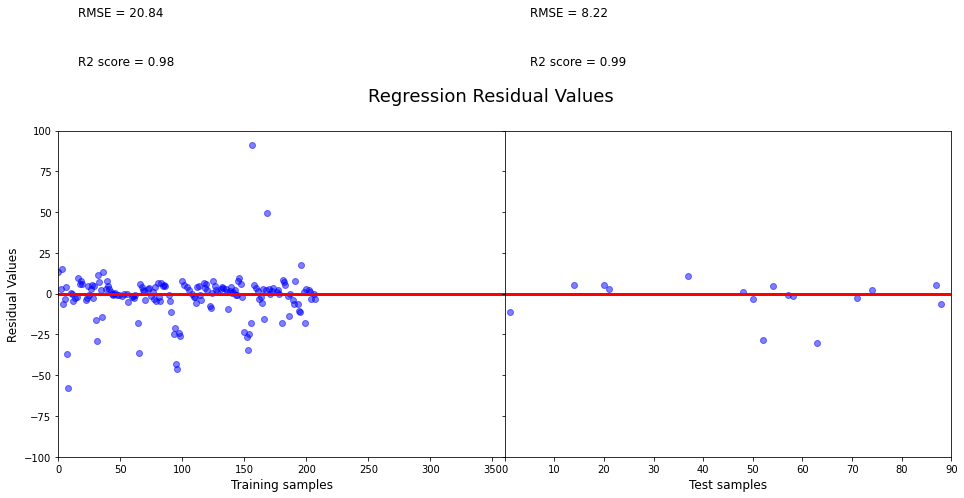

In [80]:
%matplotlib inline
from sklearn.metrics import mean_squared_error, r2_score

# Set up a multi-plot chart.
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw = {'width_ratios':[1, 1], 'wspace':0, 'hspace': 0})
f.suptitle('Regression Residual Values', fontsize = 18)
f.set_figheight(6)
f.set_figwidth(16)

# Plot residual values of training set.
a0.axis([0, 360, -100, 100])
a0.plot(y_residual_train, 'bo', alpha = 0.5)
a0.plot([-10,360],[0,0], 'r-', lw = 3)
a0.text(16,170,'RMSE = {0:.2f}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))), fontsize = 12)
a0.text(16,140,'R2 score = {0:.2f}'.format(r2_score(y_train, y_pred_train)),fontsize = 12)
a0.set_xlabel('Training samples', fontsize = 12)
a0.set_ylabel('Residual Values', fontsize = 12)

# Plot residual values of test set.
a1.axis([0, 90, -100, 100])
a1.plot(y_residual_test, 'bo', alpha = 0.5)
a1.plot([-10,360],[0,0], 'r-', lw = 3)
a1.text(5,170,'RMSE = {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))), fontsize = 12)
a1.text(5,140,'R2 score = {0:.2f}'.format(r2_score(y_test, y_pred_test)),fontsize = 12)
a1.set_xlabel('Test samples', fontsize = 12)
a1.set_yticklabels([])

plt.show()

ValueError: 'color' kwarg must be an color or sequence of color specs.  For a sequence of values to be color-mapped, use the 'c' argument instead.

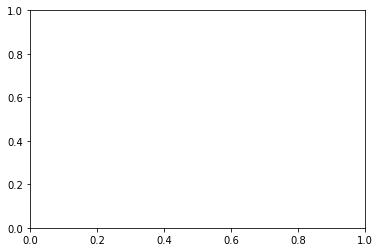

In [81]:
%matplotlib inline
test_pred = plt.scatter(y_test, y_pred_test, color='')
test_test = plt.scatter(y_test, y_test, color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()